## ⚠️ Âmes sensibles s'abstenir : Installer TensorFlow GPU sur Windows

Ce guide explique comment installer **TensorFlow 2.10.0 avec support GPU natif sur Windows**, en respectant les versions compatibles des dépendances NVIDIA.  

---

### ✅ Prérequis

- **Python** : version **3.7 à 3.10**  
- **TensorFlow** : **2.10.0** (dernière version officielle compatible GPU sous Windows natif)  
- **NVIDIA CUDA Toolkit** : **11.2**  
- **NVIDIA cuDNN** : **8.1**  
- **GPU NVIDIA** avec pilotes à jour  

---

### 🔧 Étapes d'installation

#### 1. Créer un environnement virtuel (recommandé)

```
python -m venv tf-gpu
.\tf-gpu\Scripts\activate
```

#### 2. Installer TensorFlow GPU 2.10.0

```
pip install tensorflow==2.10.0
```

#### 3. Installer CUDA 11.2 et cuDNN 8.1

- [**CUDA 11.2**](https://developer.nvidia.com/cuda-11.2.0-download-archive)
- [**cuDNN 8.1**](https://developer.nvidia.com/rdp/cudnn-archive)

#### 4. Utilisation de ```add_dll_directory```

Utilisez bien ceci pour pouvoir utiliser le GPU pour l'entrainement des modeles :

```
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")
```

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# 1. Chargement du CSV
df = pd.read_csv("traitement image/data/vectors/mediapipe_vectors.csv")
df = df.groupby('label').filter(lambda x: len(x) > 1)
print(df['label'].value_counts())
print("Classes avec moins de 2 exemples :")
print(df['label'].value_counts()[df['label'].value_counts() < 2])

label
5    70
9    70
4    69
f    68
l    68
3    68
k    67
d    66
b    65
7    65
u    63
8    61
1    60
g    54
z    54
i    53
v    52
r    52
6    51
w    49
2    49
p    48
x    47
h    46
y    35
c    33
0    29
e    23
o    15
a    15
q    13
j    13
s    12
n    11
m     8
Name: count, dtype: int64
Classes avec moins de 2 exemples :
Series([], Name: count, dtype: int64)


In [5]:
X = df.drop(columns=["label", "filename"]).values
y = df["label"].values

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
# Filtrer X_temp et y_temp pour retirer les classes avec moins de 2 exemples
import pandas as pd

# On crée un DataFrame temporaire pour faciliter le filtrage
temp_df = pd.DataFrame(X_temp)
temp_df['label'] = y_temp

# On garde uniquement les classes avec au moins 2 exemples
temp_df = temp_df.groupby('label').filter(lambda x: len(x) > 1)

# On récupère X_temp et y_temp filtrés
X_temp_filtered = temp_df.drop(columns=['label']).values
y_temp_filtered = temp_df['label'].values

# Second split
X_val, X_test, y_val, y_test = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42, stratify=y_temp_filtered)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (1297, 63) Val: (162, 63) Test: (162, 63)


In [9]:
# 3. Modèle IA (MLP)
n_classes = len(np.unique(y_encoded))
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(n_classes, activation='softmax')
])

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, verbose=1)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

Epoch 1/150
41/41 [==============================] - 1s 5ms/step - loss: 2.9707 - accuracy: 0.2429 - val_loss: 2.0669 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 2/150
41/41 [==============================] - 0s 2ms/step - loss: 1.6544 - accuracy: 0.5659 - val_loss: 1.0086 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 3/150
41/41 [==============================] - 0s 2ms/step - loss: 0.9387 - accuracy: 0.7201 - val_loss: 0.7012 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/150
41/41 [==============================] - 0s 2ms/step - loss: 0.6616 - accuracy: 0.7880 - val_loss: 0.5391 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 5/150
41/41 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.8327 - val_loss: 0.5103 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 6/150
35/41 [========================>.....] - ETA: 0s - loss: 0.4812 - accuracy: 0.8411
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
41/41 [==============================] - 0s 2ms/step - loss

In [12]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc*100:.2f}% | Test loss: {loss:.4f}")

Test accuracy: 93.21% | Test loss: 0.1950


In [13]:
import numpy as np

labels_present = np.unique(y_test)
target_names = le.inverse_transform(labels_present)
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred, labels=labels_present, target_names=target_names))

6/6 [==============================] - 0s 800us/step
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       1.00      1.00      1.00         6
           2       0.71      1.00      0.83         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       0.67      0.80      0.73         5
           7       0.86      1.00      0.92         6
           8       1.00      0.83      0.91         6
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         1
           b       1.00      1.00      1.00         7
           c       0.80      1.00      0.89         4
           d       1.00      1.00      1.00         7
           e       1.00      1.00      1.00         2
           f       1.00      1.00      1.00         7
           g       1.00     

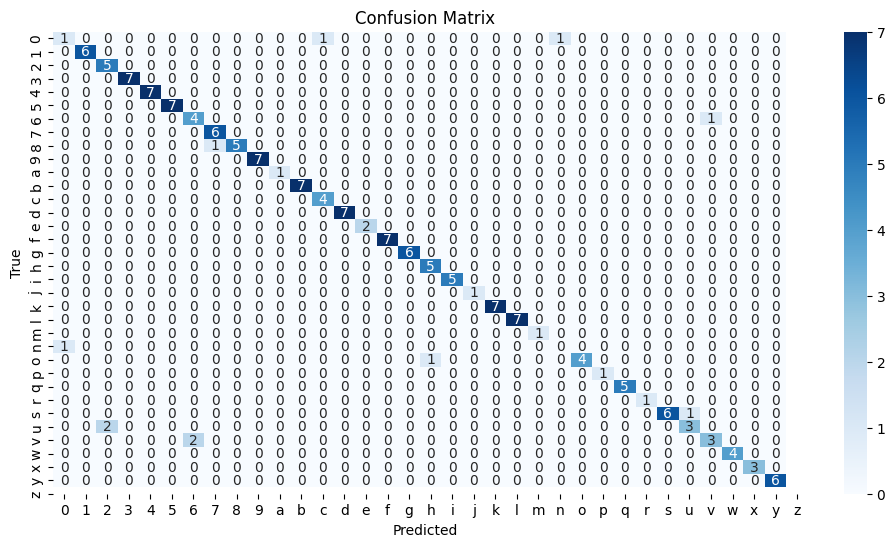

In [14]:
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
model.save("mediapipe_vector_model.h5")

1/1 [==============================] - 0s 13ms/step


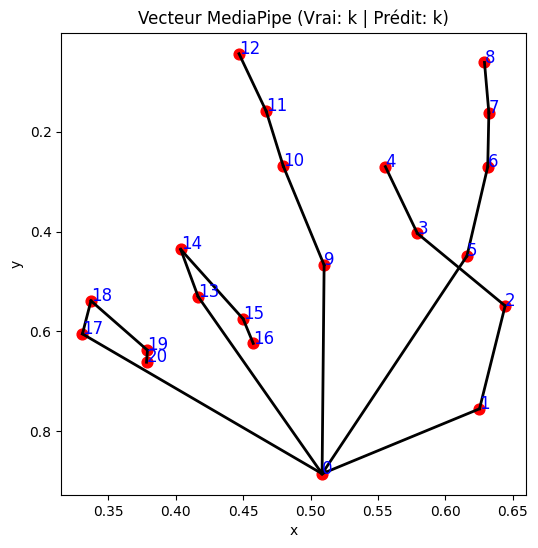

In [64]:
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(0, len(df))

# Récupérer le vecteur et le label
vector = df.drop(columns=["label", "filename"]).iloc[idx].values
label_true = df.iloc[idx]["label"]

# Appliquer le scaler
vector_scaled = scaler.transform([vector])

# Prédire
pred = model.predict(vector_scaled)
pred_class = np.argmax(pred, axis=1)[0]
label_pred = le.inverse_transform([pred_class])[0]

# Affichage graphique
points = np.array(vector).reshape(21, 3)

# Connexions MediaPipe
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9,10), (10,11), (11,12),
    (0,13), (13,14), (14,15), (15,16),
    (0,17), (17,18), (18,19), (19,20)
]

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], c='red', s=60)
for i in range(21):
    plt.text(points[i, 0], points[i, 1], str(i), fontsize=12, color='blue')

# Relier les points
for a, b in connections:
    plt.plot([points[a, 0], points[b, 0]], [points[a, 1], points[b, 1]], 'k-', lw=2)

plt.gca().invert_yaxis()
plt.title(f"Vecteur MediaPipe (Vrai: {label_true} | Prédit: {label_pred})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

1/1 [==============================] - 0s 35ms/step


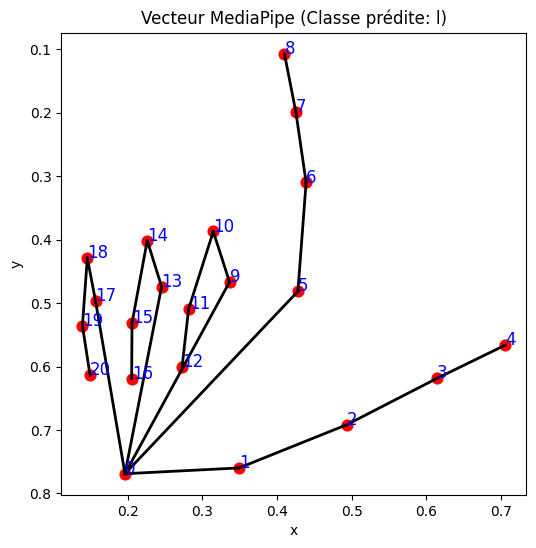

In [65]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 1. Charger le vecteur à prédire
test_vector = pd.read_csv("traitement image/data/test/test1_vectors.csv")
# test_vector = pd.read_csv("traitement image/data/test/test1_vectors.csv", header=None) # si pas de header

# 2. Appliquer le scaler (déjà entraîné)
test_vector_scaled = scaler.transform(test_vector.values)

# 3. Charger le modèle (si besoin)
model = load_model("mediapipe_vector_model.h5")

# 4. Prédire
pred = model.predict(test_vector_scaled)
pred_class = np.argmax(pred, axis=1)[0]
label_pred = le.inverse_transform([pred_class])[0]

# 5. Préparer les points
coords = test_vector.values[0]
points = np.array(coords).reshape(21, 3)

# 6. Connexions MediaPipe (doigts et paume)
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9,10), (10,11), (11,12),
    (0,13), (13,14), (14,15), (15,16),
    (0,17), (17,18), (18,19), (19,20)
]

# 7. Affichage graphique
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], c='red', s=60)
for i in range(21):
    plt.text(points[i, 0], points[i, 1], str(i), fontsize=12, color='blue')
for a, b in connections:
    plt.plot([points[a, 0], points[b, 0]], [points[a, 1], points[b, 1]], 'k-', lw=2)
plt.gca().invert_yaxis()
plt.title(f"Vecteur MediaPipe (Classe prédite: {label_pred})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()